In [1]:
from typing import Any
ModelLike = Any
SupportsPredict = Any
from pathlib import Path


def ensure_dir(path: str):
    """
    Make sure that the given path is a valid directory by creating one if missing.

    :param path: the absolute/relative path to the desired directory
    :return:
    """
    Path(path).mkdir(parents=True, exist_ok=True)
from typing import Iterable

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from pandas import DataFrame


class Performance:
    def __init__(self):
        self._df = DataFrame()

    def __setitem__(self, key, value):
        try:
            index, metric_name = key
        except:
            raise ValueError('Expecting the key to be iterable. \n'
                             'Hint: this object shall be called as `performance[index, metric_name]=metric_value`.')

        self._df.loc[index, metric_name] = value

    def __len__(self):
        return len(self._df)

    def __iter__(self):
        self._df.sort_index(inplace=True)
        return self._df.columns

    def items(self):
        return ((column, self._df[column]) for column in self._df.columns)

    def __getitem__(self, item):
        self._df.sort_index(inplace=True)
        if isinstance(item, tuple):
            raise NotImplementedError('`__getitem__` on performance object is not supported yet.')
        return self._df[item]


def plot_performance(performance: Performance, metrics_selected: Iterable[str] = None, *,
                     ax: Axes = None):
    """
    A generic plotting function for list of metric evaluations.

    :param performance:
    :param metrics_selected: a subset of metrics to be plotted, `None` means using all metrics existing.
    :param ax:
    :return:
    """

    if metrics_selected is not None:
        for name, values in performance.items():
            if name in metrics_selected:
                i = 1
                while np.isnan(values.iloc[-i]):
                    i += 1
                print(f'The ending score for metric {name} is: {values.iloc[-i]:.4e}')

    if ax is None:
        ax = plt.gca()
    for name, values in performance.items():
        if metrics_selected is None or name in metrics_selected:
            ax.plot(values.index, values, label=name)
    ax.legend(loc='best')
    ax.set(xlabel='index of fold', ylabel='metric', ylim=[-0.05, 0.1])
from pathlib import Path
from unittest import TestCase

import pandas as pd
from pandas import DataFrame


N_asset = 54
N_timeslot = 50
N_train_days = 1000
N_test_days = 700


class Dataset:
    def __init__(self, market: DataFrame, fundamental: DataFrame, ref_return: DataFrame):
        print('DeprecationWarning: load `@/data/nc/base.nc` instead!')
        self.is_train = ref_return is not None

        self.market = market
        self.fundamental = fundamental
        self.ref_return = ref_return

    def dump(self, path: str):
        ensure_dir(path)
        # Notice that the convention is to make multiindex ['day', 'asset', ?'timeslot'], but feather does not support
        # multiindex, thus we need to reset index.
        self.market.reset_index().to_feather(f'{path}/market.feather')
        self.fundamental.reset_index().to_feather(f'{path}/fundamental.feather')
        self.ref_return.reset_index().to_feather(f'{path}/ref_return.feather')

    @staticmethod
    def load(path: str = 'data/parsed'):
        try:
            market = pd.read_feather(f'{path}/market.feather').set_index(['day', 'asset', 'timeslot']).sort_index()
            fundamental = pd.read_feather(f'{path}/fundamental.feather').set_index(['day', 'asset']).sort_index()
            ref_return = pd.read_feather(f'{path}/ref_return.feather').set_index(['day', 'asset']).sort_index()
            return Dataset(market, fundamental, ref_return)
        except FileNotFoundError as e:
            print(f'Data load failed! Check if the pre-processed data is at {path}.')
            print('Hint: run the `Test.test_parse_raw_df_and_dump_full` method in `@/pipeline/parse_raw_df.py` if this'
                  'is first time to you.')
            raise e


def generate_mini_csv(n_days: int = 10, path_prefix: str = '..'):
    """
    Generate a mini dataset (usually consisting 10 days) that is useful for unittesting.

    :param n_days:
    :return:
    """
    mini_path = f'{path_prefix}/data/raw_mini/{n_days}'
    full_path = f'{path_prefix}/data/raw'
    ensure_dir(mini_path)
    template = '{}/first_round_train_{}_data.csv'
    try:
        pd.read_csv(template.format(full_path, 'fundamental')).iloc[:N_asset * n_days, :].to_csv(
            template.format(mini_path, 'fundamental'), index=False)
        pd.read_csv(template.format(full_path, 'market')).iloc[:N_asset * N_timeslot * n_days, :].to_csv(
            template.format(mini_path, 'market'), index=False)
        pd.read_csv(template.format(full_path, 'return')).iloc[:N_asset * n_days, :].to_csv(
            template.format(mini_path, 'return'), index=False)
    except FileNotFoundError as e:
        print('csv raw data not found! make sure that the training fundamental/market/return data '
              'is under the @/data/raw folder')
        raise e


def load_mini_dataset(parent_path: str = 'data/parsed_mini', n_days: int = 10, path_prefix='.'):
    market_path = f'{path_prefix}/{parent_path}/{n_days}/market.feather'
    fundamental_path = f'{path_prefix}/{parent_path}/{n_days}/fundamental.feather'
    ref_return_path = f'{path_prefix}/{parent_path}/{n_days}/ref_return.feather'
    if not Path(market_path).exists():
        print(f'Warning: could not find mini market data at `{market_path}`, trying to run the pipleline.')
        generate_mini_csv(n_days, path_prefix)
        parse_raw_df._dump(is_mini=True, n_days=n_days, path_prefix=path_prefix)

    market = pd.read_feather(market_path).set_index(['day', 'asset', 'timeslot']).sort_index()
    fundamental = pd.read_feather(fundamental_path).set_index(['day', 'asset']).sort_index()
    ref_return = pd.read_feather(ref_return_path).set_index(['day', 'asset']).sort_index()
    return Dataset(market, fundamental, ref_return)


class Test(TestCase):
    def test_generate_mini_dataset(self):
        generate_mini_csv(n_days=10)
from abc import abstractmethod
from typing import Union, Tuple, List, Optional
from unittest import TestCase

import numpy as np
import pandas as pd
from pandas import Series, DataFrame, MultiIndex
from sklearn.metrics import r2_score
from tqdm.auto import trange
from xarray import Dataset, DataArray
import xarray as xr

from qids_package.qids import make_env






Strings = Union[List[str], Tuple[str]]
idx = pd.IndexSlice


def cross_validation(model: ModelLike, feature_columns: Strings, ds: Dataset = None, return_column: str = 'return',
                     train_lookback: Optional[int] = None, per_eval_lookback: int = 1) -> Tuple[Performance, Dataset]:
    """
    Perform cross validation backtest on the given set of features.

    :param model: a model-like that supports fitting and predicting.
    :param feature_columns:
    :param ds: the full dataframe containing all necessary data
    :param return_column:
    :param train_lookback: max number of days of the training feature dataframe, `None` means no truncation.
    :param per_eval_lookback: specifies how many days are need for evaluating the prediction on one validation day.
    :return: performance: a dictionary containing the metric evaluation for each fold.
    :return: cum_y_val_df: a dataframe containing the progressive prediction of y on the validation set and the true values.
    """
    if ds is None:
        # TODO: refactor loading code
        dataset = pipeline.Dataset.load(f'{__file__}/../data/parsed')
        ds = Dataset.from_dataframe(pd.concat([dataset.fundamental, dataset.ref_return], axis=1).dropna())

    assert not ds[return_column].isnull().any().item(), 'Input return column contains NaN; maybe truncate to day 998?'

    # TODO: refactor check dataset code
    # check_dataframe(ds, expect_index=['day', 'asset'], expect_feature=feature_columns + [return_column])
    assert {'day', 'asset'}.issubset(set(ds.dims.keys()))
    assert set(feature_columns + [return_column]).issubset(set(ds.variables))

    start_day = ds.day.min().item()
    end_day = ds.day.max().item()
    val_start_day = (2 + start_day) if train_lookback is None else (per_eval_lookback + train_lookback + start_day)
    pbar = trange(val_start_day, end_day + 1)
    # pbar = trange(val_start_day, end_day - 1) # the last two days have no proper return

    performance = Performance()
    coords = ds.sel(day=slice(val_start_day, end_day)).coords
    sub_coords = {k: coords.get(k) for k in ('day', 'asset')}
    cum_y_val_prediction = DataArray(np.nan, dims=['day', 'asset'], coords=sub_coords)
    cum_y_val_true = DataArray(np.nan, dims=['day', 'asset'], coords=sub_coords)

    for val_index in pbar:
        days_train = np.arange(start_day if train_lookback is None else
                               (val_index - per_eval_lookback - train_lookback), val_index - 1)
        days_val = np.arange(val_index + 1 - per_eval_lookback, val_index + 1)

        X_train = ds[feature_columns].sel(day=days_train)
        # X_train.reindex(day=X_train.day[::-1]) #for LSTM??
        y_train_true = ds[return_column].sel(day=days_train[per_eval_lookback - 1:])
        # y_train_true.reindex(day=y_train_true.day[::-1])  # for LSTM??
        y_train_pred = model.fit_predict(X_train, y_train_true)

        y_train_prediction = DataArray(data=y_train_pred, coords=y_train_true.coords)  # TODO: check shape
        # y_train_true has shape [days_slice, assets]

        X_val = ds[feature_columns].sel(day=days_val)
        # X_val.reindex(day=X_val.day[::-1]) ## for LSTM??
        y_val_true = ds[return_column].sel(day=days_val[per_eval_lookback - 1:])
        # y_val_true.reindex(day=y_val_true.day[::-1]) ## for LSTM??
        y_val_prediction = DataArray(data=model.predict(X_val), coords=y_val_true.coords)

        cum_y_val_true.loc[dict(day=val_index)] = y_val_true.sel(day=val_index)
        cum_y_val_prediction.loc[dict(day=val_index)] = y_val_prediction.sel(day=val_index)

        train_r2 = r2_score(y_train_true.to_series(), y_train_prediction.to_series())
        performance[val_index, 'train_r2'] = train_r2
        val_r2 = r2_score(y_val_true.to_series(), y_val_prediction.to_series()) if len(
            y_val_true.to_series()) > 1 else np.nan
        performance[val_index, 'val_r2'] = val_r2
        val_pearson = y_val_true.to_series().corr(y_val_prediction.to_series()) if len(
            y_val_true.to_series()) > 1 else np.nan
        performance[val_index, 'val_pearson'] = val_pearson

        y_val_true_so_far = cum_y_val_true.sel(day=slice(start_day, val_index)).to_series()
        y_val_pred_so_far = cum_y_val_prediction.sel(day=slice(start_day, val_index)).to_series()
        val_cum_r2 = r2_score(y_val_true_so_far, y_val_pred_so_far)
        performance[val_index, 'val_cum_r2'] = val_cum_r2
        val_cum_pearson = y_val_true_so_far.corr(y_val_pred_so_far)
        performance[val_index, 'val_cum_pearson'] = val_cum_pearson

        # raise

        pbar.set_description(
            f'Validation on day {val_index}, train_r2={train_r2:.4f}, val_r2={val_r2:.4f}, val_cum_r2={val_cum_r2:.4f}, val_cum_pearson={val_cum_pearson:.4f}')

    cum_y_val_df = Dataset({k.name: k for k in (cum_y_val_true, cum_y_val_prediction)})

    return performance, cum_y_val_df


def nan_series_factory(index, name) -> Series:
    data = np.empty(len(index))
    data.fill(np.nan)
    return Series(data, index, dtype=float, name=name)


def nan_dataframe_factory(index, columns) -> DataFrame:
    data = np.empty((len(index), len(columns)))
    data.fill(np.nan)
    return DataFrame(data, index, columns, dtype=float)


class AugmentationOption:
    def __init__(
            self,
            return_lookback: int = 2,
            market_return: bool = False, market_return_lookback: int = 5,
    ):
        self.return_lookback = return_lookback
        self.market_return = market_return
        self.market_return_lookback = market_return_lookback


def evaluation_for_submission(model: ModelLike, given_ds: Dataset, qids, lookback_window: Union[int, None] = 200,
                              per_eval_lookback: int = 1, option: AugmentationOption = None) -> Tuple[Performance, Series] :
    """
    Evaluate the given model on the test dataset for submission.
    Assuming no additional features except the fundamental data and extracted market data.
    """
    N_total = N_train_days + N_test_days
    more_ds = Dataset(data_vars={k: np.nan for k in given_ds.data_vars if k != 'market_share'},
                      coords=dict(day=range(N_train_days + 1, N_total + 1), asset=range(N_asset),
                                  timeslot=range(1, N_timeslot + 1)))
    ds: Dataset = xr.combine_by_coords([given_ds, more_ds])
    ds['market_share'] = given_ds['market_share']

    if option is None:
        option = AugmentationOption()

    # Add return data from past few days
    return_0 = ds['return_0']
    for i in range(1, option.return_lookback + 1):
        return_i = return_0.shift(day=i, fill_value=0)
        ds[f'return_{i}'] = return_i

    # Add market return
    if option.market_return:
        market_return_0 = calculate_market_return(ds['return_0'])
        ds['market_return_0'] = market_return_0
        for i in range(1, option.market_return_lookback + 1):
            ds[f'market_return_{i}'] = market_return_0.shift(day=i, fill_value=0)

    # Assuming that the days start from 1; needs to be checked
    ds['return_pred'] = DataArray(data=np.nan, coords=dict(day=range(1, N_total + 1), asset=range(N_asset)),
                                  dims=['day', 'asset'])
    all_features_but_return = list(set(ds.data_vars.keys()) - {'return', 'return_pred'})

    performance = Performance()
    env = qids.make_env()
    pbar = trange(N_train_days + 1, N_train_days + N_test_days + 1)
    pbar_iter = iter(pbar)

    while not env.is_end():
        current_day = next(pbar_iter)
        before1_day = current_day - 1
        before2_day = current_day - 2

        # Obtain a slice of today's data and update to the full dataset
        new_fundamental_raw, new_market_raw = env.get_current_market()
        new_ds = pre_process_df(new_fundamental_raw, new_market_raw)
        for col in new_ds.data_vars:
            ds[col].loc[dict(day=current_day)] = new_ds[col].sel(day=current_day)

        new_market_brief = extract_market_data(
            ds[['open', 'close', 'low', 'high', 'volume', 'money']].sel(day=[before1_day, current_day])
        ).sel(day=[current_day])
        for col in new_market_brief:
            ds[col].loc[dict(day=current_day)] = new_market_brief[col].sel(day=current_day)

        return_forecast_true = ds['close_0'].sel(day=current_day) / ds['close_0'].sel(day=before2_day) - 1
        ds['return'].loc[dict(day=before2_day)] = return_forecast_true

        # Data augmentation
        if option.market_return:
            current_market_return = calculate_market_return(new_market_brief['return_0'])
            ds[current_market_return.name].loc[dict(day=current_day)] = current_market_return.sel(day=current_day)
            for i in range(1, option.market_return_lookback + 1):
                ds[f'market_return_{i}'].loc[dict(day=current_day)] = ds['market_return_0'].sel(day=current_day - i)
        for i in range(1, option.return_lookback + 1):
            ds[f'return_{i}'].loc[dict(day=current_day)] = ds[f'return_{i - 1}'].sel(day=before1_day)

        _d_ = dict(day=current_day)
        for p_f, f in ('b', 'book'), ('e_ttm', 'earnings_ttm'), ('e', 'earnings'), ('s', 'sales'), ('cf', 'cashflow'):
            ds[f].loc[_d_] = ds['close_0'].loc[_d_] / ds[f'p{p_f}'].loc[_d_]
        ds['market_cap'].loc[_d_] = ds['close_0'].sel(day=current_day) * ds['market_share']

        # Train the model on what we already have
        days_train = range(1 if lookback_window is None else (current_day - per_eval_lookback - lookback_window),
                           before1_day)
        X_train = ds[all_features_but_return].sel(day=days_train)
        assert not X_train.isnull().any().to_array().any().item()
        y_train_true = ds['return'].sel(day=days_train[per_eval_lookback - 1:])
        y_train_pred = model.fit_predict(X_train, y_train_true)
        train_r2 = r2_score(y_train_true.to_series(), y_train_pred.to_series())

        X_eval = ds[all_features_but_return].sel(day=slice(current_day + 1 - per_eval_lookback, current_day))
        assert not X_eval.isnull().any().to_array().any().item()
        y_eval_prediction = DataArray(data=model.predict(X_eval), dims=['day','asset']).rename('return_pred')
        assert set(y_eval_prediction.dims) == {'day', 'asset'}
        assert y_eval_prediction.asset.to_series().is_monotonic_increasing
        env.input_prediction(y_eval_prediction.transpose('day', 'asset').to_series())
        ds['return_pred'].loc[dict(day=current_day)] = y_eval_prediction.isel(
            day=0)  # TODO: why day information is lost in rolling_exp?

        performance[current_day, 'train_r2'] = train_r2
        if before2_day > N_train_days:
            return_forecast_pred = ds['return_pred'].sel(day=before2_day)
            test_r2 = r2_score(return_forecast_true.to_series(), return_forecast_pred.to_series())
            performance[before2_day, 'test_r2'] = test_r2
            test_pearson = return_forecast_true.to_series().corr(return_forecast_pred.to_series())
            performance[before2_day, 'test_pearson'] = test_pearson

            cum_return_true = ds['return'].sel(day=slice(N_train_days + 1, before2_day))
            cum_return_pred = ds['return_pred'].sel(day=slice(N_train_days + 1, before2_day))
            test_cum_r2 = r2_score(cum_return_true.to_series(), cum_return_pred.to_series())
            performance[before2_day, 'test_cum_r2'] = test_cum_r2
            test_cum_pearson = cum_return_true.to_series().corr(cum_return_pred.to_series())
            performance[before2_day, 'test_cum_pearson'] = test_cum_pearson

            pbar.set_description(f'Day {current_day}, train r2={train_r2:.4f}, test cum r2={test_cum_r2:.4f}, '
                                 f'test cum pearson {test_cum_pearson:.4f}')

    return performance, ds['return_pred'].to_series().iloc[1000*54:].reset_index()


class Test(TestCase):
    def test_cross_validation(self):
        """
        A minimalist set-up to show how to use the backtest cross-validation suite.
        """
        from sklearn.linear_model import LinearRegression
        from visualization.metric import plot_performance
        from matplotlib import pyplot as plt
        from datatools import data_quantization
        from pipeline import load_mini_dataset
        import matplotlib as mpl

        dataset = load_mini_dataset('data/parsed_mini', 10, path_prefix='..')
        quantized_fundamental, _ = data_quantization(dataset.fundamental)
        df = pd.concat([quantized_fundamental, dataset.fundamental, dataset.ref_return], axis=1).dropna()
        quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
        original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']

        class SimpleLinearModel(ModelLike):
            def __init__(self):
                self.reg = LinearRegression()

            def fit_predict(self, X: DataFrame, y: Series):
                print('fit:')
                print(X.index.get_level_values(0).unique())
                self.reg.fit(X, y)
                return self.reg.predict(X)

            def predict(self, X: DataFrame):
                print('predict:')
                print(X.index.get_level_values(0).unique())
                return self.reg.predict(X)

        simple_linear_model = SimpleLinearModel()

        performance, cum_y_val_df = cross_validation(simple_linear_model, quantile_feature, ds=df, train_lookback=5,
                                                     per_eval_lookback=1)
        performance, cum_y_val_df = cross_validation(simple_linear_model, quantile_feature, ds=df, train_lookback=5,
                                                     per_eval_lookback=3)

        mpl.use('TkAgg')
        plt.figure()
        plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson'])
        plt.show()

    def test_evaluation_for_submission(self):
        """
        A minimalist set-up to show how to use the evalution and submission suite.
        """
        from sklearn.linear_model import LinearRegression
        from visualization.metric import plot_performance
        from matplotlib import pyplot as plt
        from pipeline import Dataset

        dataset = Dataset.load('../data/parsed')
        # dataset = load_mini_dataset(path_prefix='..')
        df = dataset.fundamental
        f_quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                              'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
        m_quantile_feature = ['avg_price_QUANTILE', 'volatility_QUANTILE', 'mean_volume_QUANTILE']
        feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf', 'avg_price', 'volatility',
                   'mean_volume']

        class SimpleLinearModel:
            def __init__(self, features):
                self.reg = LinearRegression(fit_intercept=True)
                self.features = features

            def fit_predict(self, X, y):
                self.reg.fit(X, y)
                y_pred = self.reg.predict(X)
                return y_pred

            def predict(self, X):
                return self.reg.predict(X)

        qids = QIDS(path_prefix='../')
        # qids = None
        model = SimpleLinearModel(feature)
        performance,_ = evaluation_for_submission(model, dataset=dataset, qids=qids, lookback_window=200,
                                                option=AugmentationOption(market_return=True))

        plt.figure()
        plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
        plt.show()
from unittest import TestCase

from xarray import Dataset
import xarray as xr


def calculate_fundamental_v0(ds: Dataset):
    earnings_ttm = ds['close_0'] / ds['pe_ttm']
    earnings = ds['close_0'] / ds['pe']
    book = ds['close_0'] / ds['pb']
    sales = ds['close_0'] / ds['ps']
    cashflow = ds['close_0'] / ds['pcf']

    market_share_history = ds['volume'].sum('timeslot') / ds['turnoverRatio']
    market_share = market_share_history.sel(day=slice(990, 1000)).median(dim='day') / 1e8
    market_cap = market_share * ds['close_0']

    return Dataset(data_vars={
        'earnings_ttm': earnings_ttm,
        'earnings': earnings,
        'book': book,
        'sales': sales,
        'cashflow': cashflow,
        'market_share': market_share,
        'market_cap': market_cap,
    })


class Test(TestCase):
    def test_export_fundamental_v0(self):
        path = '../data/nc'
        base_ds = xr.open_dataset(f'{path}/base.nc')
        market_brief_ds = xr.open_dataset(f'{path}/market_brief.nc')
        ds = base_ds.merge(market_brief_ds)

        fundamental_ds = calculate_fundamental_v0(ds)
        fundamental_ds.to_netcdf(f'{path}/fundamental_v0.nc')
from unittest import TestCase

import pandas as pd
from pandas import Series, DataFrame
from xarray import Dataset



def parse_date_time_column(s: Series):
    """
    Parse the date_time field and scatter into asset/day/timeslot.

    :param s: a `Series` object where the entries follow `s[asset]d[day]p[timeslot]`
    :return: the parsed dataframe
    """
    return s.str.split(pat='s|d|p', expand=True).iloc[:, 1:].astype(int).rename(
        columns={1: 'asset', 2: 'day', 3: 'timeslot'})


def parse_date_column(s: Series):
    """
    Parse the date_time field and scatter into asset/day.

    :param s: a `Series` object where the entries follow `s[asset]d[day]`
    :return: the parsed dataframe
    """
    return s.str.split(pat='s|d', expand=True).iloc[:, 1:].astype(int).rename(columns={1: 'asset', 2: 'day'})


def pre_process_df_with_date_time_legacy(df: DataFrame):
    date_time_series = df['date_time']
    p_df = pd.concat((parse_date_time_column(date_time_series), df.drop(columns='date_time')), axis=1)
    return p_df.set_index(['day', 'asset', 'timeslot']).sort_index()


def pre_process_df_with_date_legacy(df: DataFrame):
    date_time_series = df['date_time']
    p_df = pd.concat((parse_date_column(date_time_series), df.drop(columns='date_time')), axis=1)
    return p_df.set_index(['day', 'asset']).sort_index()


def pre_process_df(f_df: DataFrame, m_df: DataFrame):
    f_ds = Dataset.from_dataframe(pre_process_df_with_date_legacy(f_df))
    m_ds = Dataset.from_dataframe(pre_process_df_with_date_time_legacy(m_df))
    return f_ds.merge(m_ds)


def _dump(is_mini: bool = False, n_days: int = 10, path_prefix='..'):
    """
    The actual working file that dumps the dataset file.

    :param is_mini:
    :param n_days:
    :return:
    """
    NC_PATH = 'data/nc'
    RAW_PATH = 'data/raw'

    nc_path = f'{path_prefix}/{NC_PATH}' + (f'_mini/{n_days}' if is_mini else '')
    raw_path = '/kaggle/input/hku-qids-2023-quantitative-investment-competition'
    template = '{}/first_round_train_{}_data.csv'
    ensure_dir(nc_path)

    try:
        f_df = pre_process_df_with_date_legacy(pd.read_csv(template.format(raw_path, 'fundamental')))
        m_df = pre_process_df_with_date_time_legacy(pd.read_csv(template.format(raw_path, 'market')))
        r_df = pre_process_df_with_date_legacy(pd.read_csv(template.format(raw_path, 'return')))
        ds = Dataset.from_dataframe(f_df)
        ds.update(Dataset.from_dataframe(m_df))
        ds.update(Dataset.from_dataframe(r_df))
        ds.to_netcdf(f'{nc_path}/base.nc')
    except FileNotFoundError as e:
        print('csv raw data not found! make sure that the training fundamental/market/return data '
              f'is under the @{raw_path} folder')
        raise e


def _dump_legacy(is_mini: bool = False, n_days: int = 10, path_prefix='..'):
    """
    The actual working file that dumps the dataset file.

    :param is_mini:
    :param n_days:
    :return:
    """
    PARSED_PATH = 'data/parsed'
    RAW_PATH = 'data/raw'

    parsed_path = '/kaggle/working/parsed'
    raw_path = '/kaggle/input/hku-qids-2023-quantitative-investment-competition'
    template = '{}/first_round_train_{}_data.csv'
    try:
        f_df = pre_process_df_with_date_legacy(pd.read_csv(template.format(raw_path, 'fundamental')))
        m_df = pre_process_df_with_date_time_legacy(pd.read_csv(template.format(raw_path, 'market')))
        r_df = pre_process_df_with_date_legacy(pd.read_csv(template.format(raw_path, 'return')))
        pipeline.Dataset(m_df, f_df, r_df).dump(parsed_path)
    except FileNotFoundError as e:
        print('csv raw data not found! make sure that the training fundamental/market/return data '
              f'is under the @{raw_path} folder')
        raise e


class Test(TestCase):
    def test_parse_raw_df_and_dump_full(self):
        _dump(is_mini=False, n_days=-1, path_prefix="/kaggle/working")

    def test_parse_raw_df_and_dump_mini(self, n_days: int = 10):
        _dump(is_mini=True, n_days=n_days)
from typing import Optional
from unittest import TestCase

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import TruncatedSVD
from xarray import DataArray, Dataset
import xarray as xr



def standardize_pd(Xin):
    """
    Parameters
    ----------
    Xin : <pd.DataFrame> dataframe containing the dataset

    Returns
    -------
    <pd.DataFrame> the column-wise standardized dataset
    """

    return Xin - Xin.min() / (Xin.max() - Xin.min())


def make_clean_data(pd_data, verbose=False):
    """
    -Given any dataframe, removes rows with nan or none, examining
    feature by feature
    -This probably can be done by doing the whole dataframe simultaneously
    """
    # infer the features we have kept by checking columns of the input dataframe

    # Needed: check all features for missing values and remove everybody with missing.
    # check remaining percentage

    features = pd_data.columns
    missing_dict = dict()
    # bad_rows = list()

    bad_rows_index = pd_data.isna().sum(axis=1).to_numpy().nonzero()
    bad_feature_index = pd_data.isna().sum().to_numpy().nonzero()
    bad_feature = pd_data.columns[bad_feature_index]

    for ft in bad_feature:
        # Calculate the percentage of that feature which was True under .isnull()
        num_missing_bool = pd_data.isna().sum()[ft]
        missing_dict[ft] = num_missing_bool / len(pd_data[ft])

        if verbose:
            print("Issue Feature:\n", ft, '\n',
                  '\n Num of null=', num_missing_bool, '\n\n')
        else:
            pass

    # for ft in features:
    #     pd_data.isna().sum()
    #     feature_series = pd_data[ft]
    #     missing_bool = feature_series.isnull()
    #     bad_indices = feature_series.index[missing_bool]
    #     #Calculate the percentage of that feature which was True under .isnull()
    #     missing_dict[ft] = 100*float(np.sum(missing_bool)/feature_series.shape[0])
    #
    #
    #     if not bad_indices.empty:
    #         if verbose:
    #             print("Issue Feature:\n", ft,'\n', bad_indices, '\n Num of null=', len(bad_indices), '\n\n')
    #             bad_rows += list(bad_indices)
    #             print('Here are Nan Indices:', bad_indices)
    #         else:
    #             pass

    # Total percentage(s) of data removed
    if verbose:
        # print('Here are Nan Row Indices:', bad_rows_index[0], '\n') #maybe we don't need but I added here
        print('Total Number of Removed Row Instances = ',
              len(bad_rows_index[0]), '\n ')
        print('Percentage of Removed Features: \n', missing_dict)
    # Eliminate duplicates and sort
    # bad_rows = list(set(bad_rows))
    # bad_rows.sort()

    # Get rid of rows containing null or empty
    # clean_data = pd_data.drop(bad_rows)
    clean_data = pd_data.drop(bad_rows_index[0])

    # Check if clean
    assert np.size(clean_data.isna().sum(axis=1).to_numpy().nonzero()[
                       0]) == 0, "Clean data still contains NaN"

    # Check the number of resulting data points
    # if verbose:
    #     print('Here is shape of original data:',data.shape,'\n\n')
    #     print('Here is shape of the clean data:', data_clean.shape,\
    #           '\n Number of Removed Instances =',len(bad_rows))

    return clean_data, missing_dict, bad_rows_index


def remove_quantiles(pd_data, p=1):
    percentile = p
    quantile = percentile / 100
    remove_indices = list()
    # feature_stats = dict()

    for feature in pd_data.columns:
        feature_series = pd_data[feature]
        quantile_filter = np.quantile(feature_series, [quantile, 1 - quantile])
        feature_outside = feature_series[(feature_series < quantile_filter[0]) | (
                feature_series > quantile_filter[1])]
        # outside_indices = feature_outside.index
        remove_indices += list(feature_outside.index)
    remove_indices = list(set(remove_indices))
    remove_indices.sort()

    pd_data_reduced = pd_data.drop(remove_indices)

    # Calculate what percent of total data is captured in these indices
    percent_removed = 100 * (len(remove_indices) / pd_data.index.shape[0])
    print('Percent of Data Removed Across These Quantiles Is: ', percent_removed)

    return pd_data_reduced, percent_removed


def run_svd(pd_data, percent_var=95):
    # def run_svd(data, rank = 3):
    """
    :pd_data: the dataframe containing the 'already standardized'] data
    :percent_var: float - a value between [0,100]
    """
    # add checking if percent_var between 0 and 100

    # Calculate the desired number of SVD components in the decomposition
    start_rank = (pd_data.shape[-1] - 1)
    # Make instance of SVD object class from scikit-learn and run the decomposition
    # Issue: scikitlearn TruncatedSVD only allows n_components < n_features (strictly)

    SVD = TruncatedSVD(n_components=start_rank)
    SVD.fit(pd_data)
    X_SVD = SVD.transform(pd_data)

    # Wrap the output as a dataframe
    X_SVD = pd.DataFrame(
        X_SVD, columns=['Singular Component ' + str(i + 1) for i in range(X_SVD.shape[-1])])

    # Calculate the number of components needed to reach variance threshold
    var_per_comp = SVD.explained_variance_ratio_

    # Calculate the total variance explainend in the first k components
    total_var = 100 * np.cumsum(var_per_comp)
    print('------------- SVD Output ----------------')
    print('Percent Variance Explained By First ' +
          str(start_rank) + ' Components: ', total_var, '\n\n')
    # rank = np.nonzero(total_var>=var_threshold)[0][0]+1
    rank = (next(x for x, val in enumerate(total_var) if val > percent_var))
    rank += 1

    if rank == 0:
        print('No quantity of components leq to ' + str(start_rank + 1) +
              ' can explain ' + str(percent_var) + '% variance.')
    else:
        print(str(total_var[rank - 1]) + '% variance ' + 'explained by ' + str(rank) + ' components. ' +
              'Variance Threshold Was ' + str(percent_var) + '.\n\n')

    return X_SVD, rank, percent_var, total_var


def data_quantization(pd_data, scale=10):
    """
    Quantize a panda data frame into integer with new features according to the given scale.
    e.g. if scale = 10: the new feature assign label 1 to the first, and 10 to the last
    :param pd_data:
    :param scale:
    :return: data_quantile: the quantized data
             percent_of_zero: at least that much percent of feature are zeros
    """
    p = np.linspace(0, scale, scale + 1) * 0.1
    data_quantile = pd_data.copy()
    percent_of_zero = {}
    eps = 1e-5

    for feature in pd_data.columns:
        feature_new = feature + '_QUANTILE'
        data_quantile[feature_new] = 0

        for (i, quantile) in enumerate(p[:-1]):
            quantile_filter = np.quantile(
                pd_data[feature], [quantile, p[i + 1]])
            data_quantile.loc[((pd_data[feature] > quantile_filter[0]) &
                               (pd_data[feature] <= quantile_filter[1])), feature_new] = i + 1

            # deal with 0-quantile being non-zero
            if i == 0 and quantile_filter[0] > 0:
                data_quantile.loc[((pd_data[feature] >= quantile_filter[0]) &
                                   (pd_data[feature] <= quantile_filter[1])), feature_new] = i + 1

            if quantile_filter[0] <= eps and quantile_filter[1] >= eps:
                percent_of_zero[feature] = quantile
            elif quantile_filter[0] > eps and i == 0:
                percent_of_zero[feature] = 0

        data_quantile.drop(columns=feature, axis=1, inplace=True)
    return data_quantile, percent_of_zero


def extract_market_data_legacy(m_df: DataFrame):
    """
    Input the market data and extract mean price using close
    prices, volatility, daily return and mean volume
    :param m_df: [pd.DataFrame] market data, set_index already
    :return: [pd.DataFrame] extracted features from market data
    """
    # sort indexing
    if m_df.index.names == ['asset', 'day', 'timeslot']:
        m_df = m_df.swaplevel(0, 1)
    elif m_df.index.names == ['day', 'asset', 'timeslot']:
        pass
    else:
        raise ValueError('Unsupported index ordering')

    m_df.sort_index(ascending=True, inplace=True)

    m_df_day = m_df.groupby(level=[0, 1])[['volume', 'money']].sum()
    # Compute average price
    m_df_day['avg_price'] = m_df_day['money'] / m_df_day['volume']
    # find index of zero volume
    indx_day = m_df_day[m_df_day['volume'] == 0].index
    # compute replacing value as mean of high and low
    for (i, indx) in enumerate(indx_day):
        replace_value = .5 * m_df.loc[indx, 'high'].max() + .5 * m_df.loc[indx, 'low'].min()
        m_df_day.loc[indx, 'avg_price'] = replace_value

    assert np.size(m_df_day.isna().sum(axis=1).to_numpy().nonzero()[
                       0]) == 0, "Clean data still contains NaN"

    # Compute volatility
    T = 50.0  # number of time units
    # note numpy use 0 dof while pd use 1 dof
    m_df_day['volatility'] = m_df.groupby(level=[0, 1])['close'].std() * np.sqrt(T)

    # Compute average volume:
    m_df_day['mean_volume'] = m_df_day['volume'] / T

    # drop unnecessary features:
    m_df_day = m_df_day.drop(columns=['volume', 'money'])

    # Daily return that compares the first open and the last close
    price_groupby = m_df.reset_index(level=[0, 1]).groupby(by=['day', 'asset'])
    close_price = price_groupby['close'].take([N_timeslot - 1]).reset_index('timeslot', drop=True).rename('return_0')
    open_price = price_groupby['open'].take([0]).reset_index('timeslot', drop=True).rename('return_0')

    day_1_return = close_price.iloc[:N_asset] / open_price.iloc[:N_asset] - 1
    remaining_day_return = close_price.iloc[N_asset:] / close_price.shift(N_asset)[N_asset:] - 1

    m_df_day['return_0'] = pd.concat([day_1_return, remaining_day_return])
    m_df_day['close_0'] = m_df.groupby(level=[0, 1])['close'].take([N_timeslot - 1]).values
    return m_df_day


def extract_market_data(ds: Dataset):
    """
    Input the market data and extract mean price using close
    prices, volatility, daily return and mean volume
    :param ds: [xr.Dataset] dataset that contains market data
    :return: [xr.Dataset] extracted features from market data
    """
    assert not ds.isnull().any().to_array().any().item()

    day_money_sum = ds['money'].sum('timeslot')
    day_volume_sum = ds['volume'].sum('timeslot')
    avg_price = day_money_sum / day_volume_sum
    day_volume_s = day_volume_sum.to_series()
    indx_day = day_volume_s.where(day_volume_s == 0).dropna()

    for day_idx, asset_idx in indx_day.index:
        sub_ds = ds.sel(day=day_idx, asset=asset_idx)
        replace_value = (sub_ds['high'].max() + sub_ds['low'].min()) / 2
        avg_price.loc[dict(day=day_idx, asset=asset_idx)] = replace_value

    assert not avg_price.isnull().any().item(), "Clean data still contains NaN"

    # Compute volatility
    T = len(ds.timeslot)  # number of time units
    # note numpy use 0 dof while pd use 1 dof
    volatility = ds['close'].std('timeslot', ddof=1) * np.sqrt(T)

    # Compute average volume:
    mean_volume = day_volume_sum / T

    # Daily return that compares the first open and the last close
    daily_close_price = ds['close'].sel(timeslot=T, drop=True)
    daily_open_price = ds['open'].sel(timeslot=1, drop=True)
    daily_high_price = ds['high'].max(dim='timeslot')
    daily_low_price = ds['low'].min(dim='timeslot')

    previous_close_price = daily_close_price.shift(day=1)
    previous_close_price[dict(day=0)] = daily_open_price.isel(day=0)
    daily_return = daily_close_price / previous_close_price - 1

    return Dataset(dict(
        avg_price=avg_price,
        volatility=volatility,
        mean_volume=mean_volume,
        close_0=daily_close_price,
        open_0=daily_open_price,
        high_0=daily_high_price,
        low_0=daily_low_price,
        return_0=daily_return,
    ))


def check_dataframe(df, expect_index=None, expect_feature=None, shutup=True):
    """
    Check if the input DataFrame contains NaN, and check the desired index and features if provided
    :param df[pd.DataFrame]: input dataframe to check
    :param expect_index[list]: input list for expected indices in df
    :param expect_feature[list]: input list for expected features in df
    :return:
    """
    if expect_index is not None and df.index.names != expect_index:
        raise ValueError('Expecting index as {} but got {}'.format(expect_index, list[df.index.names]))
    else:
        if not shutup:
            print('Indices matched')

    if expect_feature is not None and not set(expect_feature).issubset(set(df.columns)):
        raise ValueError(f'Expecting feature as {expect_feature} but got {df.columns}')
    else:
        if not shutup:
            print('Features matched')

    if df.isnull().values.any():
        raise ValueError('DataFrame still contains NaN')
    if not shutup:
        print('DataFame is all good for the tests')


def calculate_market_return_legacy(
        df: DataFrame, return_0_column: str = 'return_0', weight: Optional[np.ndarray] = None,
) -> Series:
    """
    Calculate the market daily return by combining the return for each asset according to the given weight.

    :param df: Dataframe containing the daily return data.
    :param return_0_column:
    :param weight:
    :return:
    """
    check_dataframe(df, expect_index=['day', 'asset'], expect_feature=[return_0_column])
    if weight is not None:
        raise ValueError('Currently, only `weight=None` (i.e. simple average) is supported.')
    else:
        # Simple return
        market_return = df.groupby(level=0)[return_0_column].mean()

    return market_return.rename(f'market_{return_0_column}')


def calculate_market_return(return_0: DataArray, weight: Optional[np.ndarray] = None, ) -> DataArray:
    """
    Calculate the market daily return by combining the return for each asset according to the given weight.
    """
    # assert {'day', 'asset'}.issubset(set(return_0.dims))
    if weight is not None:
        raise ValueError('Currently, only `weight=None` (i.e. simple average) is supported.')
    else:
        # Simple return
        market_return = return_0.mean(dim='asset')

    return market_return.rename(f'market_return_0')

def generate_sbumission(pred: Series, filename: str) -> None:
    """
    generate csv for Kaggle submission
    :param pred: input prediction from eval_to_submission; contain columns 'day' 'asset' and 'return_pred'
    :param filename: path to the saved file
    :return:
    """
    pred['date_time'] = 's' + pred['asset'].astype(str) + 'd' + pred['day'].astype(str)
    pred = pred.drop(['day', 'asset'], axis=1).rename(columns={'return_pred': 'return'})
    pred = pred[['date_time', 'return']]
    pred.to_csv(filename, index=False)

class Test(TestCase):
    def test_export_extract_market(self):
        ds = xr.open_dataset('data/nc/base.nc')
        market_brief = extract_market_data(ds[['money', 'volume', 'close', 'open', 'high', 'low']])
        market_brief.to_netcdf('data/nc/market_brief.nc')

    def test_compare_extract_market(self):
        market_brief = xr.open_dataset('data/nc/market_brief.nc')
        dataset = pipeline.Dataset.load('data/parsed')
        market_legacy = extract_market_data_legacy(dataset.market)
        for col in market_legacy:
            assert np.isclose(market_brief.to_dataframe()[col], market_legacy[col]).all()

    def test_checkdata(self):
        from pipeline import load_mini_dataset

        dataset = load_mini_dataset('./data/parsed_mini', 10)
        quantized_fundamental, _ = data_quantization(dataset.fundamental)
        df = pd.concat([quantized_fundamental, dataset.fundamental, dataset.ref_return], axis=1).dropna()
        quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
        original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']
        quantile_feature.extend(original_feature)
        quantile_feature.append('return')
        check_dataframe(df, expect_index=['day', 'asset'], expect_feature=df.columns)
        check_dataframe(df, expect_index=['day', 'asset'], expect_feature=quantile_feature)


if __name__ == "__main__":
    pass
from datetime import date
from typing import Optional, Callable, Tuple
from unittest import TestCase

import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from pandas import Series, DataFrame
from sklearn.preprocessing import RobustScaler
from torch import nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

import torch.nn.functional as F
import xarray as xr
from xarray import Dataset, DataArray

from torchmetrics import PearsonCorrCoef

idx = pd.IndexSlice


def _num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


def _device_helper(is_cuda):
    return 'cuda' if is_cuda else 'cpu'


class CUDAModule(nn.Module):
    def __init__(self, is_cuda: bool):
        super().__init__()
        self.is_cuda = is_cuda
        self.device = _device_helper(self.is_cuda)
        self._has_moved = False

    def move(self):
        self._has_moved = True
        self.to(self.device)

    def forward_device_independent(self, x: torch.Tensor):
        raise NotImplementedError

    def forward(self, x: torch.Tensor):
        if not self._has_moved:
            print('This module might have not been moved to the correct device!')

        return self.forward_device_independent(x.to(self.device)).to('cpu')


class MLP(CUDAModule):
    """
    Fully connected NN
    """

    def __init__(self, D_out, input_shape, is_cuda: bool = True):
        """

        :param D_out: number of classes label
        :param input_shape:
        :param is_cuda:
        """
        super(MLP, self).__init__(is_cuda)

        self.fc1 = nn.Linear(input_shape[1] * input_shape[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, D_out)
        self.dropout = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()

        # self.final_layer = nn.Softmax()

        self.move()

    def forward_device_independent(self, x):
        x = x.contiguous().view(-1, _num_flat_features(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.dropout(self.fc3(x))))
        x = self.fc4(x)
        # x = self.final_layer(x)
        return x


class LSTM(CUDAModule):
    def __init__(self, num_output, num_features, hidden_size, num_layers, is_cuda: bool = False):
        """

        Remark:
            1. hidden_size is like embedding feature space dimension
            2. better > num_assets?
                # if num_layers = 2: stack 2 LSTM of lyaer 1:
                # nn.Sequential(OrderedDict([
                #     ('LSTM1', nn.LSTM(input_size, hidden_size, 1),
                #     ('LSTM2', nn.LSTM(hidden_size, hidden_size, 1)
                #     ]))
        :param num_output:
        :param num_features:
        :param hidden_size:
        :param num_layers:
        :param is_cuda:
        """
        super(LSTM, self).__init__(is_cuda)
        self.num_output = num_output
        self.num_layers = num_layers
        self.num_features = num_features
        self.hidden_size = hidden_size
        # LSTM input size (batch_first) (batch, seq_length, feature)
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_output)

        self.move()

    def forward_device_independent(self, x: torch.Tensor):
        """

        Remark: the second dim for h_0 and c_0 is the batch dim
        :param x:
        :return:
        """
        batch_size = x.shape[0]
        # TODO: review: Variable if deprecated
        # https://pytorch.org/docs/stable/autograd.html?highlight=variable#variable-deprecated
        h_0 = torch.randn(self.num_layers, batch_size, self.hidden_size, device=self.device)  # hidden state
        c_0 = torch.randn(self.num_layers, batch_size, self.hidden_size, device=self.device)  # cell state

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # get only the last hidden layer, needed for multiple layer
        h_out = h_out[-1, :, :].view(-1, self.hidden_size)

        out = self.fc(self.dropout(h_out))

        return out


class oneDVerConvNet(CUDAModule):
    def __init__(self, D_in, D_out, input_shape, b_size, is_cuda: bool = True, activation: str = 'relu'):
        # input_shape: without batch dimension
        # b_size: batch size
        super(oneDVerConvNet, self).__init__(is_cuda)
        self.activation = nn.ReLU() if activation == 'relu' else nn.Tanh()
        self.layer1 = nn.Sequential(
            nn.Conv2d(D_in, 16, (3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(16),  # no batch
            self.activation,
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(64),
            self.activation,
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(256),
            self.activation,
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 1024, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0)),
            nn.BatchNorm2d(1024),
            self.activation,
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)))
        self.drop_out = nn.Dropout()
        n_size = self._get_conv_output(input_shape, b_size)
        self.fc1 = nn.Linear(n_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, D_out)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)

        self.move()

    def _get_conv_output(self, shape, b_size):
        input = Variable(torch.rand(b_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(b_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # print(x.shape) # shape = (b_size, feature=1024, H=1, W = 54)
        x = torch.max(x, 3)[0]
        return x

    def forward_device_independent(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.max(x, 3)[0]  # questionable maybe do along [1]

        x = x.view(-1, _num_flat_features(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.drop_out(self.fc2(x))))
        x = self.fc3(x)
        # x = F.relu(self.transform1(x))
        # x = F.relu(self.drop_out(self.transform2(x)))
        # x = self.transform3(x)
        return x.squeeze()


class Transformer(CUDAModule):
    def __init__(self, n_class: int, seq_length: int, feature: list, hidden_size: int, output_size: int,
                 num_layer: int = 1, is_cuda: bool = False, offset_feature_size: Optional[int] = None):
        super(Transformer, self).__init__(is_cuda)
        self.n_feature = len(feature)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layer = num_layer

        self.class_dim = n_class
        self.time_dim = seq_length
        # self.class_embed = nn.Embedding(self.class_dim, self.) # try without embedding first

        self.embed_feature_dim = self.n_feature  # no embedding
        ## one-hot encoding and positional encoding:
        if 'offset_feature' in feature:
            self.is_time_embed = True
#             self.time_embed = nn.Embedding(offset_feature_size, self.time_dim)
#             self.embed_feature_dim += self.time_dim-1
            self.time_embed = nn.Embedding(offset_feature_size, 8)
            self.embed_feature_dim += 7
            self.day_feature_indx = feature.index('offset_feature')
        else:
            self.is_time_embed = False

        if 'asset_name' in feature:
            self.embed_feature_dim += 53
            self.is_asset_embed = True
            self.asset_name_indx = feature.index('asset_name')
        else:
            self.is_asset_embed = False
                    
        if 'season_day' in feature:
            self.is_season_embed = True
            self.season_embed = nn.Embedding(65, 8)
            self.embed_feature_dim += 7
            self.season_day_indx = feature.index('season_day')
        else:
            self.is_season_embed = False
            
        print('embedding feature dimension is', self.embed_feature_dim)

        self.linear_1 = nn.Linear(self.embed_feature_dim, self.hidden_size)
        self.bn1 = nn.BatchNorm1d(self.time_dim)
#         self.drop_out = nn.Dropout1d(p=0.2)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.hidden_size,
                                                   nhead=8,
                                                   dropout=0.0,
                                                   batch_first=True,
                                                   )
        self.encoder = nn.TransformerEncoder(encoder_layer, self.num_layer)
        self.linear_2 = nn.Linear(self.hidden_size, self.output_size)
        self.move()

    def forward_device_independent(self, x: torch.Tensor):
        columns_indx = torch.arange(x.shape[-1]).long()
        # print('original indx', columns_indx)
        indx_remain_bool = torch.ones(columns_indx.shape).long()
#         print(x.shape)

        if self.is_time_embed:
#             print("offset index", self.day_feature_indx)
            day_feature = x[:, :, self.day_feature_indx].long()
            day_feature = self.time_embed(day_feature)
            indx_remain_bool *= (columns_indx != self.day_feature_indx)

        if self.is_asset_embed:
#             print("asset index:", self.asset_name_indx)
            asset_name = x[:, :, self.asset_name_indx]
            # print(x)
            # print(asset_name)
            # print(asset_name.max())
            assert asset_name.max().item() <= 54
            asset_name = F.one_hot(asset_name.long(), 54)
            indx_remain_bool *= (columns_indx != self.asset_name_indx)
            
        if self.is_season_embed:
            season_day = x[:, :, self.season_day_indx].long()
            season_day = self.season_embed(season_day)
            indx_remain_bool *= (columns_indx != self.season_day_indx)
        

        # print('remain indices:', columns_indx[indx_remain_bool.long()==1])

        # get data out except for embedded ones
        x = x[:, :, indx_remain_bool.long() == 1]
        # print(x.shape)
        if self.is_time_embed:
            x = torch.cat((x, day_feature), dim=-1)
        if self.is_asset_embed:
            x = torch.cat((x, asset_name), dim=-1)
        if self.is_season_embed:
            x = torch.cat((x, season_day), dim=-1)
            
        # print(x.shape) # (432, 4, 71)
#         x = self.drop_out(x)
        x = self.linear_1(x)
#         x = self.drop_out(x)
#         x = self.bn1(x)
        h = self.encoder(x)
        h = h.mean(dim=1)
        outputs = self.linear_2(h)
        return outputs.squeeze()


class SimpleLinearNetwork(nn.Module):
    def __init__(self, D_in):
        super(SimpleLinearNetwork, self).__init__()
        self.fc = nn.Linear(D_in, 1)

    def forward(self, x):
        x = torch.transpose(x[:, :, 0, :], 1, 2)
        return self.fc(x).squeeze()


def easy_winsorize(s: Series, trim_ratio: float = 0.05):
    return np.clip(s, s.quantile(trim_ratio), s.quantile(1 - trim_ratio))


class DataPreprocessing:
    def __init__(self):
        self.scaler = RobustScaler()

    def unskew(self, X: DataFrame):
        return DataFrame({
            'log_turnoverRatio': np.log(X['turnoverRatio']),
            'log_transactionAmount_pos': np.log(X['transactionAmount'] + 1),
            'log_pb': np.log(X['pb']),
            'log_ps': np.log(X['ps']),
            # 'winsor_pe_ttm': easy_winsorize(X['pe_ttm']),
            'winsor_pe': easy_winsorize(X['pe']),
            'winsor_pcf': easy_winsorize(X['pcf']),
        })

    def working(self, X: DataFrame, t):
        # return DataFrame(t(self.unskew(X)), index=X.index, columns=list(set(X.columns) - {'return_0+1'})
        #                  ).merge(X['return_0+1'], on=['day', 'asset'])
        tX = self.unskew(X)
        aa = (X['return_0'] + 1) * (X['return_1'] + 1) - 1
        df = DataFrame(t(tX), index=tX.index, columns=tX.columns)
        df['return_0+1'] = aa
        return df

    def fit_transform(self, X: DataFrame):
        return self.working(X, lambda Y: self.scaler.fit_transform(Y))

    def transform(self, X: DataFrame):
        return self.working(X, lambda Y: self.scaler.transform(Y))


    
class TransformerOpt:
    "Optim wrapper that implements rate for Transformer."
    def __init__(self, optimizer, hidden_size, warmup_steps):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup_steps
        self.model_size = hidden_size
        self._rate = 0
    
    def state_dict(self):
        """Returns the state of the warmup scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer.
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}
    
    def load_state_dict(self, state_dict):
        """Loads the warmup scheduler's state.
        Arguments:
            state_dict (dict): warmup scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict) 
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5))) 
    
def _get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
    
    

class Neg_Pearson_Loss(nn.Module):
    def __init__(self) -> None:
        super(Neg_Pearson_Loss, self).__init__()

    def forward(self, pred, target):
        # loss_without_reduction = max(0, −target * (input1 − input2) + margin)
        pearson = PearsonCorrCoef()
        return -pearson(pred.squeeze(), target.squeeze())


class MonStEr_Loss(nn.Module):
    def __int__(self) -> None:
        super(MonStEr_Loss, self).__int__()

    def forward(self, pred_, target_):
        pred = pred_/0.2
        target = target_/0.2
        loss = 0
        # is_tar_pos = target >= 0
        # is_pred_ge_tar = pred >= target

        is_dir_correct= torch.sign(pred-target) == torch.sign(target)
        # print(target.max())
        loss += torch.sum(is_dir_correct*(1/(1+0.1*torch.abs(target)))*torch.abs(pred-target)\
             + (~is_dir_correct)*torch.pow(torch.abs(target - pred), 1+4*torch.abs(target)))


        # loss += torch.sum(is_tar_pos * is_pred_ge_tar * (1 / (1 + 4 * target) * (pred - target)) \
        #         + is_tar_pos * (~is_pred_ge_tar) * torch.pow(target - pred, 1 + target) \
        #         + (~is_tar_pos) * is_pred_ge_tar * torch.pow(target - pred, 1 - target) \
        #         + (~is_tar_pos) * (~is_pred_ge_tar) * (1 / (1 + 4 * target) * (target - pred)))

        return loss


class NN_wrapper:
    def __init__(
            self, preprocess, lr=0.001, criterion=nn.MSELoss(), n_epoch=5, train_lookback=32, per_eval_lookback=16,
            n_asset=54, hidden_size=64, lr_scheduler_constructor: Optional[Callable] = None, network='LSTM',
            is_eval: bool = False, feature_name=None, load_model_path=None, is_cuda=True, embed_season: bool = False,
            embed_offset: bool = False, embed_asset: bool = False, l2_weight=1e-5, l1_weight=0, var_weight=0
    ):
        if feature_name is None:
            raise ValueError('Please provide a list of feature')
        feature_to_nn = feature_name.copy()
        if embed_offset:
            feature_to_nn += ['offset_feature']
        if embed_asset:
            feature_to_nn += ['asset_name']
#         if embed_season:
#             feature_to_nn += ['season_day']
        n_feature = len(feature_name)

        if network == 'LSTM':
            self.net = LSTM(num_output=1, num_features=n_feature, hidden_size=hidden_size, num_layers=1,
                            is_cuda=is_cuda)
        elif network == 'MLP':
            self.net = MLP(D_out=1, input_shape=[n_asset * train_lookback, per_eval_lookback, n_feature],
                           is_cuda=is_cuda)
        elif network == 'CONV':
            self.net = oneDVerConvNet(D_in=1, D_out=1, input_shape=[1, per_eval_lookback, n_feature],
                                      b_size=train_lookback * n_asset, is_cuda=is_cuda)
        elif network == 'Transformer':
            self.net = Transformer(n_class=n_asset, seq_length=per_eval_lookback, feature=feature_to_nn,
                                   hidden_size=hidden_size, output_size=1, is_cuda=is_cuda,
                                   offset_feature_size=per_eval_lookback)
        else:
            raise ValueError('Network architecture not supported')

        if is_eval:
            if load_model_path is None:
                raise ValueError('Please provide model path to load')
            else:
                self.net.load_state_dict(torch.load(load_model_path))

        if load_model_path is not None:
            self.net.load_state_dict(torch.load(load_model_path))

        self.is_eval = is_eval
        self.feature_name = feature_name
        self.feature_to_nn = feature_to_nn
        self.n_epoch = n_epoch

        if criterion == 'pearson':
            self.criterion = Neg_Pearson_Loss()
        elif criterion == 'monster':
            self.criterion = MonStEr_Loss()
        elif criterion == 'combined':
            self.criterion = 'combined'
        else:
            self.criterion = criterion

        self.train_lookback = train_lookback
        self.per_eval_lookback = per_eval_lookback
        self.n_asset = n_asset
        self.net_name = network
        self.embed_asset = embed_asset
        self.embed_offset = embed_offset
        self.embed_season = embed_season

        # regularization parameter
        self.l1_weight = l1_weight
        self.var_weight = var_weight

        # Define the optimizier
        ## optimizer with L2-regularization
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=l2_weight)
#         self.optimizer = optim.Adagrad(self.net.parameters(), lr=lr, weight_decay=l2_weight, eps=1e-9)
#         self.optimizer = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9, weight_decay=l2_weight)
    
        ## original optimizer
        # self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999))

        
        # self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=lr / 10, max_lr=lr,
        #                                              step_size_up=n_epoch // 2, cycle_momentum=False)
        if lr_scheduler_constructor is None:
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100000, gamma=0.5)
        elif lr_scheduler_constructor == "warmup":
            self.scheduler = TransformerOpt(self.optimizer, hidden_size, 3000)
        else:
            self.scheduler = lr_scheduler_constructor(self.optimizer)

        self.preprocess = preprocess
        self.is_learning = True
        # self.early_stopper = EarlyStopper(patience=3, min_delta=10)

    def prepare_X(self, X: Dataset, fit: bool, lookback: int) -> Tuple[torch.Tensor, DataArray]:
        start_day = X.day.min().to_numpy().item()

        X_pd = X[self.feature_name].to_dataframe(dim_order=['day', 'asset'])

        ## Minmax scale except for the asset name (category)
        X_pd[X_pd.columns] = self.preprocess.fit_transform(X_pd.values) if fit else self.preprocess.transform(
            X_pd.values)
        X_transformed = xr.Dataset.from_dataframe(X_pd)

        # New data preprocessing with Xarray - Hooray!
        X_list = []
        for i in range(lookback):
            X_slice = X_transformed.sel(
                day=slice(start_day + i, start_day + i + self.per_eval_lookback - 1)).expand_dims(
                batch=[start_day + i + self.per_eval_lookback - 1])
            X_slice.coords['offset'] = X_slice.day - start_day - i  # calculate offset coordinate/index for each slice
            X_slice_o = X_slice.swap_dims(
                {'day': 'offset'})  # swap to make offset the dimension instead of the previous 'day'
            X_list.append(X_slice_o.reset_coords(drop=True))  # (reset and) drop all non-index coordinates
        X_concat = xr.concat(X_list, dim='batch')  # concat along the batch dimension
        if self.embed_offset:
            X_concat = X_concat.assign(offset_feature=X_concat.offset)
        if self.embed_asset:
            X_concat = X_concat.assign(asset_name=X_concat.asset)
#         if self.embed_season:
#             X_concat = X_concat.assign(season_day=X_concat.day)
#             X_concat['season_day'] = X_concat['season_day'] % 65
            
        # create a new batch dimension cartesian product all batch and asset
        X_arr = (X_concat.stack({'batch_asset': ['batch', 'asset']}).to_array('feature')
                 .transpose('batch_asset', 'offset', 'feature'))
        X_arr_np = X_arr.to_numpy()

        if self.net_name == 'CONV':
            X_arr_np = X_arr_np[:, np.newaxis, :, :]

        # then reshape into the desire form for NN (batch, seq_length, feature)
        # batch_asset "is" a multi-index array, with the ordering of train_lookback, asset
        X_tensor = torch.from_numpy(X_arr_np).to(torch.float)
        return X_tensor, X_arr.batch_asset

    def fit_predict(self, X: Dataset, y: DataArray):
        self.net.train()
        X_tensor, batch_asset = self.prepare_X(X, fit=True, lookback=self.train_lookback)
        y_tensor = torch.from_numpy(y.stack({'batch_asset': ['day', 'asset']}).values).to(torch.float)


        # LSTM or NN shape (batch, seq_length, feature)
        for epoch in range(self.n_epoch):
            self.optimizer.zero_grad()
            outputs = self.net(X_tensor).squeeze()

            if self.criterion == 'combined':
                mse_loss = nn.MSELoss()
#                 mse_loss = nn.L1Loss()
                pearson_loss = Neg_Pearson_Loss()
                loss = mse_loss(outputs, y_tensor) + pearson_loss(outputs, y_tensor)
            else:
                loss = self.criterion(outputs, y_tensor)

            if epoch == 1:
                print('training loss:', loss.item())

            ## add L1 regularization
            if self.l1_weight > 0:
                l1_norm = sum(torch.linalg.norm(p, 1) for p in self.net.parameters())
                loss += self.l1_weight * l1_norm

            if self.var_weight > 0 and isinstance(self.criterion, nn.MSELoss):
                # print('variance is computed')
                loss += self.var_weight * torch.abs(torch.var(outputs) - torch.var(y_tensor))

            ## check parameter values
            # print(list(self.net.parameters()))

            ## check parameter name and require_grad
            # for name, param in self.net.named_parameters():
            #     print(name, param.requires_grad)

            loss.backward()
            
#             torch.nn.utils.clip_grad_norm_(self.net.parameters(), 2, norm_type='inf')
            
            self.optimizer.step()
            self.scheduler.step()

        if X.day.max().to_numpy().item() >= 994 and not self.is_eval:  # save final model
            dump_folder = 'model/dump/' + str(date.today())
            self.model_path = dump_folder + '/' + str(date.today()) + '_' + self.net_name
            ensure_dir(dump_folder)
            torch.save(self.net.state_dict(), self.model_path)
            print('Final learning rate:', _get_lr(self.optimizer))

        return xr.DataArray(data=outputs.detach().numpy(), coords=dict(batch_asset=batch_asset)).unstack(
            'batch_asset').rename({'batch': 'day'})

    def predict(self, X):
        self.net.eval()
        X_tensor, _ = self.prepare_X(X, fit=False, lookback=1)
        y = self.net(X_tensor).squeeze()

        # return np.clip(y.detach().numpy(), -0.2, 0.2)[np.newaxis, :]  # return a numpy array
        return y.detach().numpy()[np.newaxis, :]  # for predicting correlation


class Test(TestCase):
    def test_nn(self):
        """
        Adapted from `playground/disaspeare/Feb_17_NN_MLP.ipynb`

        :return:
        """
        from pipeline import Dataset
        import pandas as pd
        from torch import nn
        from datatools import check_dataframe
        from pipeline.backtest import cross_validation
        from matplotlib import pyplot as plt
        from visualization.metric import plot_performance

        dataset = Dataset.load('../data/parsed')
        df = pd.concat([dataset.fundamental, dataset.ref_return], axis=1).dropna()

        check_dataframe(df, expect_index=['day', 'asset'])
        df['return_0+1'] = df['return'].shift(2 * 54).fillna(0)

        train_lookback = 64
        eval_lookback = 16
        n_epoch = 100
        lr = 0.001
        criterion = nn.MSELoss()
        # optimizer = 'LBFGS'
        optimizer = 'ADAM'
        original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe', 'pcf', 'return_0+1']
        n_asset = 54

        pp = DataPreprocessing()
        my_nn = NN_wrapper(pp, None, eval_lookback, train_lookback, optimizer=optimizer, learning_rate=lr,
                           criterion=criterion, n_epoch=n_epoch, n_asset=n_asset, n_feature=len(original_feature))
        performance, pred_df = cross_validation(my_nn, feature_columns=original_feature,
                                                df=df.query(f'asset < {n_asset}'),
                                                per_eval_lookback=eval_lookback, train_lookback=train_lookback)

        plt.figure()
        plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
        plt.ylim([-0.15, 0.1])
        plt.show()

    def test_monster(self):
        import torch

        a=torch.rand(10)
        b=torch.rand(10)
        criterion = MonStEr_Loss()
        loss = criterion(a,b)
        print(a,'\n')
        print(b, '\n')
        print(loss)

In [2]:
from pathlib import Path

import numpy as np
import torch
import xarray as xr
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import RobustScaler
from torch import optim

from qids_package.qids import make_env


In [3]:
##### Load necessary dataset and create them if not present
path = '/kaggle/working/data/nc'
base_nc_path = f'{path}/base.nc'
if not Path(base_nc_path).exists():
    _dump(is_mini=False, n_days=-1, path_prefix="/kaggle/working")
base_ds = xr.open_dataset(base_nc_path)

market_brief_path = f'{path}/market_brief.nc'
if not Path(market_brief_path).exists():
    market_brief = extract_market_data(base_ds[['money', 'volume', 'close', 'open', 'high', 'low']])
    market_brief.to_netcdf(market_brief_path)
market_brief_ds = xr.open_dataset(market_brief_path)
ds = base_ds.merge(market_brief_ds)

fundamental_path = f'{path}/fundamental_v0.nc'
if not Path(fundamental_path).exists():
    fundamental_ds = calculate_fundamental_v0(ds)
    fundamental_ds.to_netcdf(fundamental_path)
else:
    fundamental_ds = xr.open_dataset(fundamental_path)
ds = ds.merge(fundamental_ds)
# ds = ds.assign(season_day=ds.day)
# ds['season_day'] = ds['season_day']%65



In [4]:
##### Datatools extension
def winsorize(X, q=0.1):
    lower = X.quantile(q)
    upper = X.quantile(1 - q)
    return X.clip(lower, upper, axis=1)


class CombinedScaler:
    def __init__(self):
        self.scaler = RobustScaler()

    def fit_transform(self, X):
        X = winsorize(DataFrame(X))
        return self.scaler.fit_transform(X)

    def transform(self, X):
        X = winsorize(DataFrame(X))
        return self.scaler.transform(X)



In [5]:
##### CUDA
IS_CUDA = torch.cuda.is_available()
print(f'>>>> IS_CUDA={IS_CUDA} <<<<<')


>>>> IS_CUDA=True <<<<<


In [6]:
list(ds.keys())

['turnoverRatio',
 'transactionAmount',
 'pe_ttm',
 'pe',
 'pb',
 'ps',
 'pcf',
 'open',
 'close',
 'high',
 'low',
 'volume',
 'money',
 'return',
 'avg_price',
 'volatility',
 'mean_volume',
 'close_0',
 'open_0',
 'high_0',
 'low_0',
 'return_0',
 'earnings_ttm',
 'earnings',
 'book',
 'sales',
 'cashflow',
 'market_share',
 'market_cap']

embedding feature dimension is 68


  0%|          | 0/779 [00:00<?, ?it/s]

training loss: -0.17869335412979126
training loss: -0.30174222588539124
training loss: -0.34048211574554443
training loss: -0.31195497512817383
training loss: -0.30805519223213196
training loss: -0.3255724012851715
training loss: -0.3039170205593109
training loss: -0.25568804144859314
training loss: -0.2633281350135803
training loss: -0.3088696002960205
training loss: -0.18904311954975128
training loss: -0.29769131541252136
training loss: -0.35028716921806335
training loss: -0.34908345341682434
training loss: -0.3472144603729248
training loss: -0.3157746493816376
training loss: -0.32196253538131714
training loss: -0.3164793848991394
training loss: -0.21273422241210938
training loss: -0.2127295881509781
training loss: -0.28493064641952515
training loss: -0.3168867826461792
training loss: -0.34707680344581604
training loss: -0.3536568582057953
training loss: -0.2918056547641754
training loss: -0.2641312777996063
training loss: -0.25688600540161133
training loss: -0.3444454073905945
train

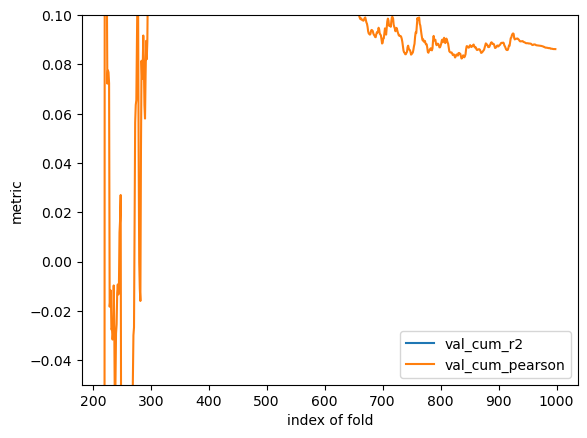

In [7]:
##### Actually learning (?)
HIDDEN_SIZE = 2048
train_lookback = 16
eval_lookback = 4
feature = ['book', 'cashflow', 'sales', 'earnings_ttm', 'earnings', 'market_cap']
# feature = ['cashflow', 'market_cap', 'market_share']
# feature = ['avg_price', 'mean_volume', 'market_share', 'market_cap', 'return_0']
# feature = ['avg_price']

preprocess = CombinedScaler()
lr = 5e-4 # use 0 if warmup scheduler
n_epoch = 10


constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr / 10, max_lr=lr, step_size_up=n_epoch // 2,
                                                    cycle_momentum=False)

torch.manual_seed(2023)
np.random.seed(2023)

model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=constructor, n_epoch=n_epoch,
                   train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=HIDDEN_SIZE, n_asset=54,
                   network='Transformer', feature_name=feature, load_model_path=None, criterion='pearson',
                   embed_asset=True, embed_offset=True, embed_season=False, is_eval=False, var_weight=0,
                   is_cuda=IS_CUDA)
ds_cv = ds.sel(day=slice(200, ds.dims['day'] - 2))[feature + ['return']]
performance_cv, cum_y_df = cross_validation(model, feature, ds=ds_cv, train_lookback=train_lookback,
                                            per_eval_lookback=eval_lookback)

plt.figure(0)
plot_performance(performance_cv, metrics_selected=['val_cum_pearson', 'val_cum_r2'])
plt.show()
# 

In [8]:
!ls /kaggle/working/model/dump

2023-03-15


In [9]:
!ls -l /kaggle/working/model/dump/2023-03-10

ls: cannot access '/kaggle/working/model/dump/2023-03-10': No such file or directory


In [10]:
!date

Wed Mar 15 19:24:47 UTC 2023


embedding feature dimension is 68
Environment is initialized.


  0%|          | 0/700 [00:00<?, ?it/s]

training loss: -0.22408004105091095
training loss: -0.20688092708587646
training loss: -0.21102730929851532
training loss: -0.21210788190364838
training loss: -0.19244790077209473
training loss: -0.18687377870082855
training loss: -0.1875665932893753
training loss: -0.19684401154518127
training loss: -0.21644748747348785
training loss: -0.22576501965522766
training loss: -0.2373756766319275
training loss: -0.2432093471288681
training loss: -0.24149298667907715
training loss: -0.26965659856796265
training loss: -0.31386256217956543
training loss: -0.32540565729141235
training loss: -0.35092541575431824
training loss: -0.34193238615989685
training loss: -0.3244868218898773
training loss: -0.3430067002773285
training loss: -0.3829655647277832
training loss: -0.42139652371406555
training loss: -0.4067866802215576
training loss: -0.3996012508869171
training loss: -0.4330771565437317
training loss: -0.4437102973461151
training loss: -0.4676865041255951
training loss: -0.3535626232624054
trai

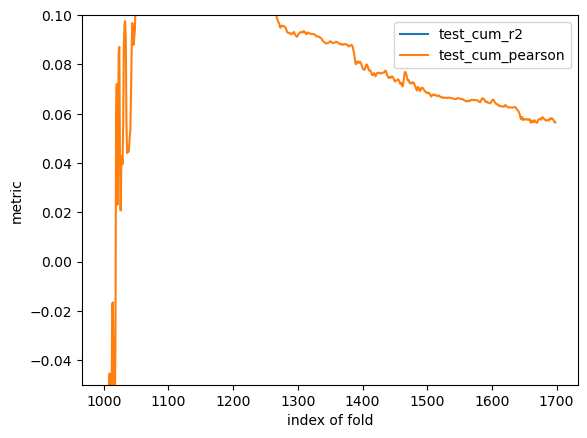

In [11]:
##### Evaluation
from qids_package import qids
'model/dump/' 
load_model_path = '/kaggle/working/model/dump/'+ str(date.today()) + '/'+ str(date.today()) + '_Transformer'
preprocess = CombinedScaler()
lr = 5e-4
n_epoch = 2
# constructor = lambda o: optim.lr_scheduler.CyclicLR(o, base_lr=lr/10, max_lr=lr, step_size_up=n_epoch // 2,
#                                                     cycle_momentum=False)
torch.manual_seed(2023)
np.random.seed(2023)

model = NN_wrapper(preprocess=preprocess, lr=lr, lr_scheduler_constructor=None, n_epoch=n_epoch,
                   train_lookback=train_lookback, per_eval_lookback=eval_lookback, hidden_size=HIDDEN_SIZE, n_asset=54,
                   network='Transformer', feature_name=feature, load_model_path=load_model_path,
                   embed_asset=True, embed_offset=True, criterion='pearson', l2_weight=1e-5,
                   is_eval=True,
                   is_cuda=IS_CUDA)
performance_eval, y_pred = evaluation_for_submission(model, given_ds=ds, lookback_window=train_lookback,
                                                     per_eval_lookback=eval_lookback, qids=qids)
plt.figure(0)
plot_performance(performance_eval, metrics_selected=['test_cum_pearson', 'test_cum_r2'])
plt.show()